# Descripción del proyecto



Trabajas para la tienda online Ice que vende videojuegos por todo el mundo. Las reseñas de usuarios y expertos, los géneros, las plataformas (por ejemplo, Xbox o PlayStation) y los datos históricos sobre las ventas de juegos están disponibles en fuentes abiertas. Tienes que identificar patrones que determinen si un juego tiene éxito o no. Esto te permitirá detectar proyectos prometedores y planificar campañas publicitarias.

Delante de ti hay datos que se remontan a 2016. Imaginemos que es diciembre de 2016 y estás planeando una campaña para 2017.



## Importar librerías y el conjunto de datos

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from scipy import stats as st
from scipy.stats import levene, ttest_ind

In [2]:
games = pd.read_csv('/datasets/games.csv')

Procedo a revisar los datos antes de procesarlos

In [3]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


## Limpieza y preparación de datos

### Duplicados

Reviso si hay duplicados y los elimino de ser necesario

In [5]:
games.duplicated().sum()

0

### Columnas

Convierto a snake_case los nombres de columnas

In [6]:
games.columns = games.columns.str.lower()

#### Names

In [7]:
games[games['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Son solo dos filas que además son nulas casi en su totalidad, considero no serán útiles para el análisis así que las elimino

In [8]:
games = games.dropna(subset=['name'])

#### Platform

Columna lista para el análisis

#### Year of release

Hay muchos juegos sin año de lanzamiento así que para poder tener un aproximado en el tiempo activo de la plataforma averiguo la mediana por plataforma y reemplazo los valores nulos con el año correspondiente creando una función para ello.

In [9]:
median_years = games.groupby('platform')['year_of_release'].median()

In [10]:
def null_x_median(data):  
    if pd.isnull(data['year_of_release']):
        return median_years[data['platform']]
    else:
        return data['year_of_release']

games['year_of_release'] = games.apply(null_x_median, axis=1)

Por legibilidad cambio el tipo de datos de float a int

In [11]:
games['year_of_release'] = games['year_of_release'].astype(int)

#### Genre

Los nulos en esta columna eran los mismos que en columna 'name'

#### Sales

Sin problemas con estas columnas. Creo una nueva columna para las ventas totales a nivel global

In [12]:
games['total_sales']= games['na_sales']+games['eu_sales']+games['jp_sales']+games['other_sales']

#### Critic score

Reemplazar valores nulos en 'critic_score' con la mediana del conjunto

In [13]:
crit_median = games['critic_score'].median()

In [14]:
games['critic_score'] = games['critic_score'].fillna(crit_median)


Transformo 'critic_score' a la misma escala de 'user_score' para poder comparar adecuadamente

In [15]:
games['critic_score']=games['critic_score']/10

#### User score

En la columna 'user_score', 'tbd' no me da información relevante así que primero lo reemplazaré con nulos para luego hacer la conversión de tipo de datos y finalmente reemplazar nulos por la mediana igual que en la columna anterior

In [16]:
games['user_score'] = games['user_score'].replace('tbd', np.nan).astype(float)

In [17]:
user_median = games['user_score'].median()

In [18]:
games['user_score'] = games['user_score'].fillna(user_median)

#### Rating

Son datos cualitativos asi que no puedo usar información estadistica como media o mediana para rellenar los nulos ni tampoco puedo asignar un valor arbitrario. Cuando estos datos sean relevantes para el análisis, trabajaré solo los datos no nulos a modo de muestra poblacional.

## Análisis

### Cuántos juegos fueron lanzados en diferentes años. ¿Son significativos los datos de cada período?

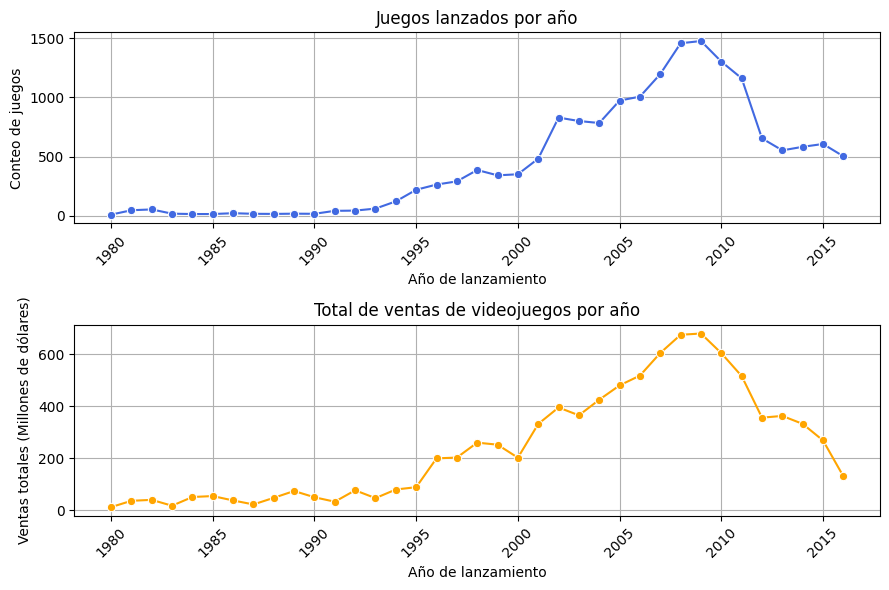

In [53]:
# Gráfico de juegos lanzados
games_per_year = games['year_of_release'].value_counts().sort_index()

plt.figure(figsize = (9, 6))
plt.subplot(2, 1, 1)
sns.lineplot(x = games_per_year.index, 
             y = games_per_year.values,
             marker = 'o',
             color = 'royalblue')
plt.title('Juegos lanzados por año')
plt.xlabel('Año de lanzamiento')
plt.ylabel('Conteo de juegos')
plt.xticks(rotation = 45)
plt.grid(True)

# Gráfico de ventas totales
sales_per_year = games.groupby('year_of_release')['total_sales'].sum().reset_index()

# Crear el gráfico de barras
plt.subplot(2, 1, 2)
sns.lineplot(data = sales_per_year, x = 'year_of_release', 
            y = 'total_sales', 
            marker = 'o',
            color = 'orange')
plt.title('Total de ventas de videojuegos por año')
plt.xlabel('Año de lanzamiento')
plt.ylabel('Ventas totales (Millones de dólares)')
plt.xticks(rotation = 45)
plt.grid(True)

plt.tight_layout()
plt.show()

Es a partir de mediados de los 90s que comienza a crecer el auge por los videojuegos y es en el año 2009 cuando tiene su punto más alto. Ambos gráficos tienen formas muy parecidas por lo que parece haber una relación directa entre ambas variables; me propongo averiguarlo usando el método de correlación de Pearson

In [20]:
# Agrupo los datos de ventas y cantidad de juegos por año
annual_data = games.groupby('year_of_release').agg(total_sales=('total_sales', 'sum'), total_games=('name', 'count')).reset_index()

# Calculo el coeficiente de correlación de Pearson
correlation, p_value = st.pearsonr(annual_data['total_sales'], annual_data['total_games'])
print(f'Pearson: {correlation:.2}')
print(f'P-value: {p_value:.2e}')

Pearson: 0.98
P-value: 7.32e-27


Ciertamente hay una muy fuerte correlación entre la cantidad de juegos lanzados y las ventas de cada año y el p_value muestra que no es casualidad; tiene sentido pensar de ese modo antes de hacer cualquier comparación pero ahora tenemos un respaldo para futuros análisis. 

### Cómo varían las ventas de una plataforma a otra. Elige las plataformas con las mayores ventas totales y construye una distribución basada en los datos de cada año. Busca las plataformas que solían ser populares pero que ahora no tienen ventas. ¿Cuánto tardan generalmente las nuevas plataformas en aparecer y las antiguas en desaparecer?

Primero observo la comparativa de ventas totales de cada plataforma, eso me dará una idea de cuales serán de mi interés.

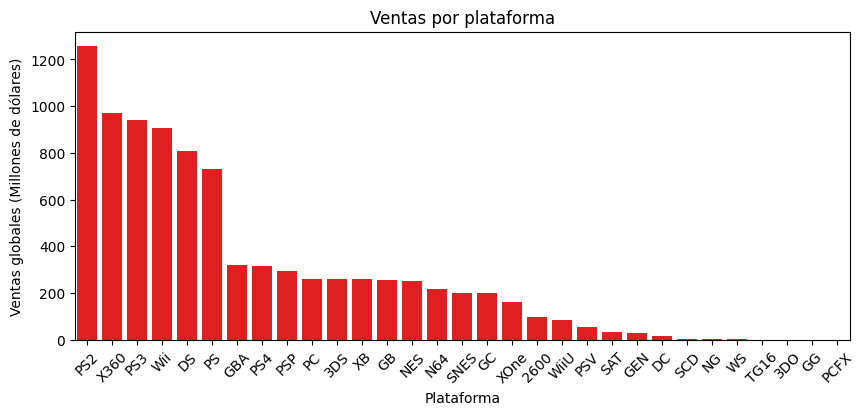

In [21]:
sales_by_platform = games.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

plt.figure(figsize = (10, 4))
sns.barplot(x = sales_by_platform.index, 
            y = sales_by_platform.values,
            color = 'red')
plt.title('Ventas por plataforma')
plt.xlabel('Plataforma')
plt.ylabel('Ventas globales (Millones de dólares)')
plt.xticks(rotation = 45)
plt.show()

Historicamente PS2 es la plataforma más exitosa seguida por X360, PS3, Wii, DS y PS respectivamente.
Sin embargo los datos abarcan varias décadas y en el area de tecnología que algo sea exitoso en el pasado no garantiza su éxito futuro por lo que es necesario mayor análisis para crear un plan de mercado efectivo.

Mostrar las ventas de todas las plataformas a traves del tiempo en un solo gráfico lo hace muy dificil de comprender y crear gráficos individuales para cada plataforma no es eficiente así que para facilitar el análisis y comparación crearé una función con un gráfico interactivo que permita elegir cuales plataformas mostrar y también el rango de tiempo que quiero evaluar.

Primero creo los menús interactivos para elegir plataforma y rango de tiempo:

In [22]:
# Menú de selección múltiple de plataforma
platforms_list = sorted(games['platform'].unique())

platform_selector = widgets.SelectMultiple(options = platforms_list, 
                                           description = 'Plataforma:')


# Menú de selección múltiple y deslizador de rango de años
years = (games['year_of_release'].min(), games['year_of_release'].max())

year_selector = widgets.IntRangeSlider(value = years,
                                       min = years[0],
                                       max = years[1],
                                       description = 'Años:',
                                       continuous_update = False,)

Ahora la función que graficará los parametros elegidos:

In [63]:
def select_platform(platform, year_range):
    # Filtra df en función de los parámetros y luego agrupa los datos
    filtered = games[games['platform'].isin(platform)]
    filtered = filtered[(filtered['year_of_release'] >= year_range[0]) & (filtered['year_of_release'] <= year_range[1])]
    sales_by_year = filtered.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()
    
    plt.figure(figsize = (10, 5))
    sns.lineplot(data = sales_by_year, 
                 x = 'year_of_release', 
                 y = 'total_sales', 
                 hue = 'platform', 
                 marker = 'o')
    plt.title(f'Historial de ventas por plataforma')
    plt.xlabel('Año de lanzamiento')
    plt.ylabel('Ventas totales (en millones de dólares)')
    plt.xticks(rotation = 45)
    plt.legend(title = 'Plataforma', loc = 'upper right')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.15, 1.05))
    plt.show()
    
# Integrar el menú de selección y mostrar el gráfico
game_plot = widgets.interactive(select_platform, 
                                platform = platform_selector, 
                                year_range = year_selector)

# Mostrar el gráfico
game_plot

interactive(children=(SelectMultiple(description='Plataforma:', index=(20, 21, 22, 23, 24, 25, 26, 27, 28, 29,…

Hay algunas plataformas que tuvieron ventas muy bajas y desaparecieron rápidamente, las consideradas exitosas tienen un ciclo de vida de aproximado de seis a diez años, dependiendo de su éxito comercial (PC es una excepción ya que se actualiza constantemente lo que garantiza su existencia a futuro)

### Determina para qué período debes tomar datos. 
Las plataformas tienen ciclos de vida de algunos años, no tiene sentido hacer proyecciones sobre juegos para plataformas antiguas por lo que tomaré desde 2013 ya que fue el año en que salieron las más recientes y son las que actualmente dominan el mercado

### ¿Qué plataformas son líderes en ventas? ¿Cuáles crecen y cuáles se reducen? Elige varias plataformas potencialmente rentables.

Teniendo en cuenta el análisis anterior, he decidido enfocarme en 5 plataformas para las proyecciones: PC por lo explicado anteriormente, XOne, WiiU y PS4 por ser las más nuevas de las compañías más grandes y 3DS por ser la portátil con más ventas en los úlitmos años. Todas las demás plataformas han desaparecido o tienen ventas muy bajas y seguirán bajando pues el público tiende a ir hacia las más actuales por lo que no veo conveniente destinar recursos a su promoción.

PS4 es la más rentable de todas con aproximadamente el doble de ventas de XOne que es la que le sigue, estas dos son las más recientes y es muy probable que sus ventas aumenten el próximo año. Luego están 3DS y WiiU las cuales parecen haber tenido su mejor momento en años anteriores al 2016 pero aun son atractivas al público. Finalmente PC es la de menores ventas de la lista pero al ser una plataforma actualizable seguirá usandose por mucho tiempo por lo que no debe dejarse de lado.

PD: Es importante resaltar que aunque en el año actual (2016) todas tienen menores ventas, diciembre es una época de un incremento fuerte y las ventas de este més pueden no estar reflejadas en los datos.

Filtrado con base en lo anterior

In [24]:
filtered_games = games[(games['platform'].isin(['PC', 'PS4', 'WiiU', 'XOne', '3DS'])) & (games['year_of_release'] >= 2013)]

Ya con el nuevo df, exploramos para obtener más información 

In [25]:
sales_data = filtered_games.groupby('platform').agg(total_games=('name', 'count'), 
                                             total_sales=('total_sales', 'sum'), 
                                             mean_sale= ('total_sales', lambda x: round(x.mean(), 2)),
                                             median=('total_sales', 'median'),
                                             higher_sale=('total_sales', 'max')).reset_index()

In [26]:
sales_data

,platform,total_games,total_sales,mean_sale,median,higher_sale
0,3DS,311,144.44,0.46,0.09,14.60
1,PC,189,39.43,0.21,0.08,3.05
2,PS4,392,314.14,0.80,0.20,14.63
3,WiiU,115,64.63,0.56,0.20,7.09
4,XOne,247,159.32,0.65,0.22,7.39


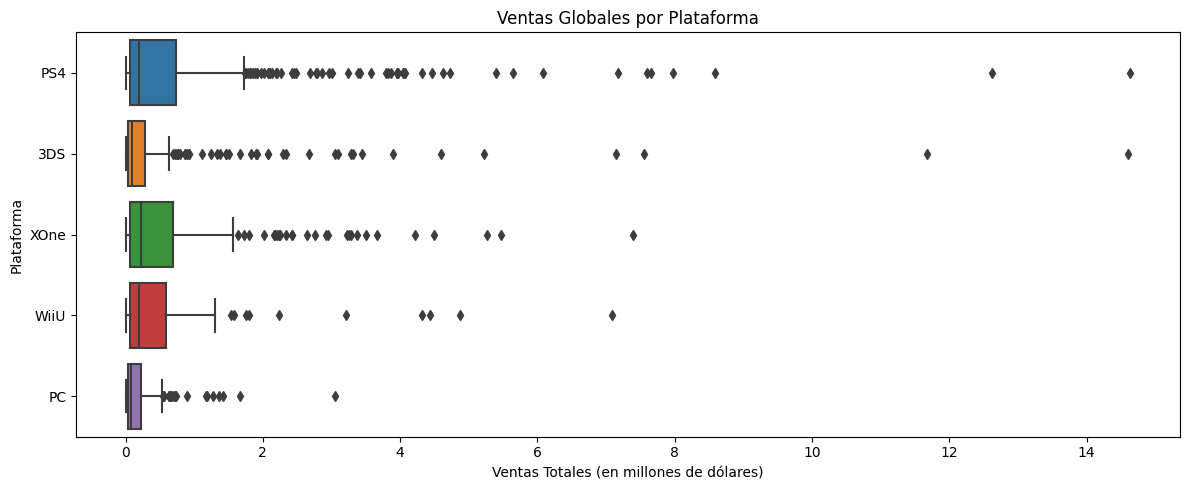

In [27]:
# Diagrama de caja de ventas
plt.figure(figsize = (12, 5))
sns.boxplot(data = filtered_games,
            x = 'total_sales', 
            y = 'platform' )
plt.title('Ventas Globales por Plataforma')
plt.xlabel('Ventas Totales (en millones de dólares)')
plt.ylabel('Plataforma')
plt.tight_layout()
plt.show()

Observando la tabla recién creada y la distribución en el diagrama de caja se puede concluir que la mayoría de juegos tienen ventas muy bajas sin variar demasiado por plataforma y que los mayores éxitos en ventas son valores atípicos.

Al ser PS4 la plataforma con mayores ventas y número de juegos del conjunto, analizaré en mayor porfundidad.

Quiero ver el comportamiento de las ventas comparándo el juego con la calificación dada tanto por críticos como por usuarios

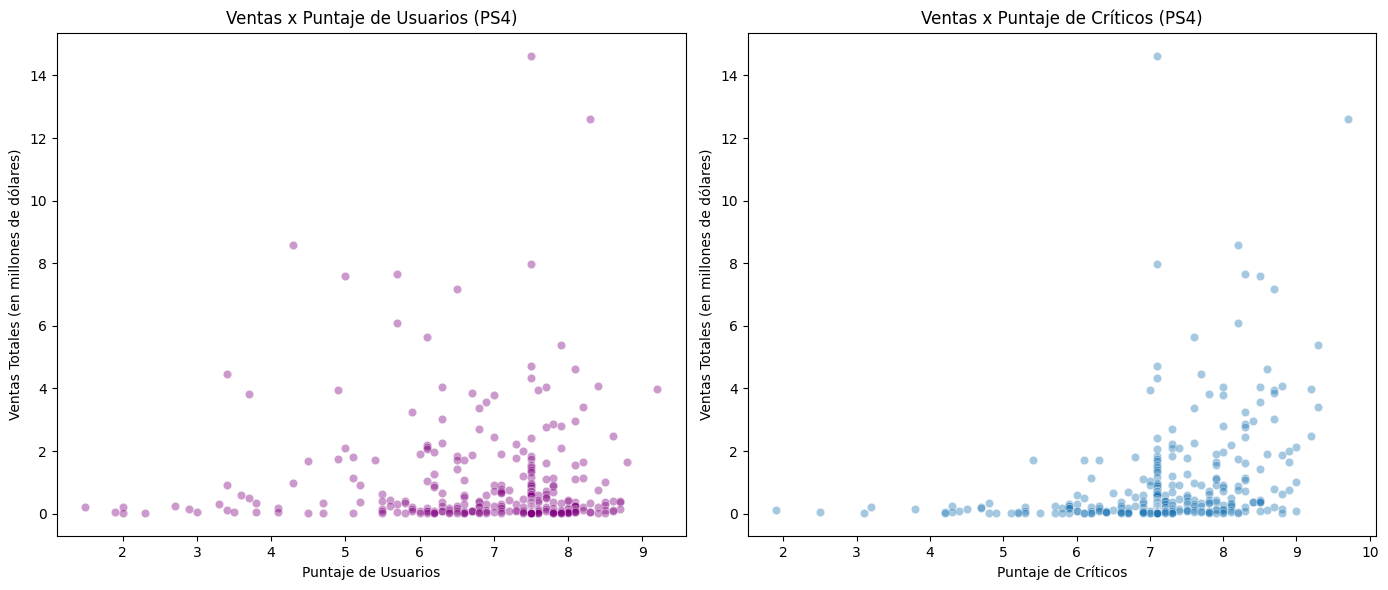

In [28]:
# Primero filtrar los datos de PS4
psfour = filtered_games[filtered_games['platform'] == 'PS4']

# Crear gráficos de dispersión
plt.figure(figsize=(14, 6))

# Gráfico de usuarios
plt.subplot(1, 2, 1)
sns.scatterplot(data = psfour,
                x = 'user_score', 
                y = 'total_sales', 
                color = 'purple', 
                alpha = 0.4)
plt.title('Ventas x Puntaje de Usuarios (PS4)')
plt.xlabel('Puntaje de Usuarios')
plt.ylabel('Ventas Totales (en millones de dólares)')

# Gráfico de críticos
plt.subplot(1, 2, 2)
sns.scatterplot(data = psfour,
                x = 'critic_score', 
                y = 'total_sales', 
                alpha = 0.4)
plt.title('Ventas x Puntaje de Críticos (PS4)')
plt.xlabel('Puntaje de Críticos')
plt.ylabel('Ventas Totales (en millones de dólares)')

plt.tight_layout()
plt.show()

In [29]:
# Calcular el coeficiente de correlación de Pearson
user_corr = psfour['user_score'].corr(psfour['total_sales'])
critic_corr = psfour['critic_score'].corr(psfour['total_sales'])

print(f'La calificación de los usuarios en relación a las ventas es: {user_corr:.2f}')
print(f'La calificación de la crítica en relación a las ventas es: {critic_corr:.2f}')

La calificación de los usuarios en relación a las ventas es: -0.06
La calificación de la crítica en relación a las ventas es: 0.34


Ambos grupos tienden a dar un puntaje alto en promedio pero los resultados muestran de que la calificación dada por los usuarios no tiene virtualmente ninguna relación con las ventas mientras que el puntaje de los críticos muestra una ligera relación positiva pero en la que no puede confiarse para predecir ventas efectivamente.

### Compara las ventas de los mismos juegos en otras plataformas.

In [30]:
#Filtrar juegos lanzados en varias plataformas
multi_plat = filtered_games['name'].value_counts()
multi_plat = multi_plat[multi_plat > 1].index
multi_game = filtered_games[filtered_games['name'].isin(multi_plat)]

In [31]:
# Tabla dinamica con las ventas
game_pivoted = multi_game.pivot_table(index='name', 
                                      columns='platform', 
                                      values='total_sales', 
                                      aggfunc='sum').reset_index()

# Incluir solo juegos que fueron lanzados en PS4
ps_pivoted = game_pivoted[game_pivoted['PS4'].notnull()]

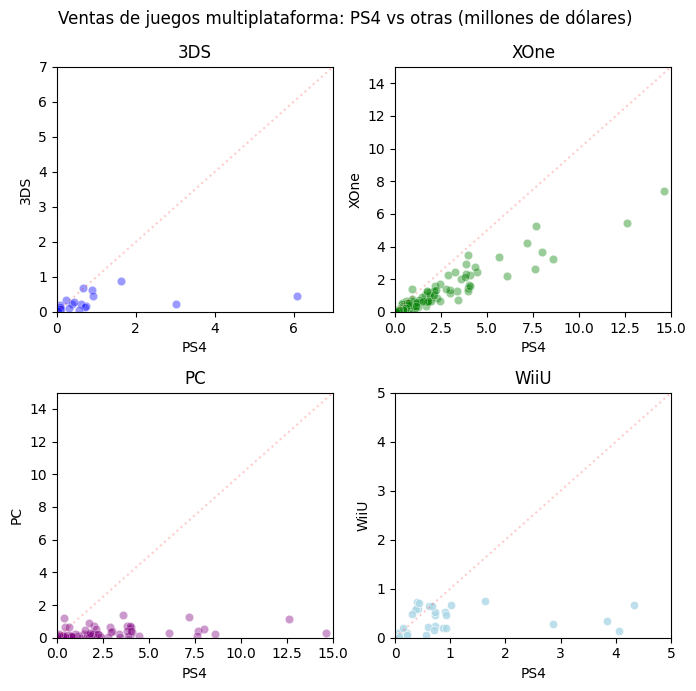

In [67]:
#Gráfico comparativo de ventas entre PS4 y otras plataformas
plt.figure(figsize=(7, 7))
plt.suptitle('Ventas de juegos multiplataforma: PS4 vs otras (millones de dólares)')
# 3DS
plt.subplot(2, 2, 1)
sns.scatterplot(data = ps_pivoted,
                x = 'PS4', 
                y = '3DS', 
                color = 'blue', 
                alpha = 0.4)
plt.title('3DS')
plt.xlabel('PS4')
plt.ylabel('3DS')
plt.xlim(0,7)
plt.ylim(0,7)
plt.plot([0, 7], [0, 7], color='red', linestyle=':', alpha = 0.2)

# XOne
plt.subplot(2, 2, 2)
sns.scatterplot(data = ps_pivoted,
                x = 'PS4', 
                y = 'XOne', 
                color = 'green', 
                alpha = 0.4)
plt.title('XOne')
plt.xlabel('PS4')
plt.ylabel('XOne')
plt.xlim(0,15)
plt.ylim(0,15)
plt.plot([0, 15], [0, 15], color='red', linestyle=':', alpha = 0.2)

# PC
plt.subplot(2, 2, 3)
sns.scatterplot(data = ps_pivoted,
                x = 'PS4', 
                y = 'PC', 
                color = 'purple', 
                alpha = 0.4)
plt.title('PC')
plt.xlabel('PS4')
plt.ylabel('PC')
plt.xlim(0,15)
plt.ylim(0,15)
plt.plot([0, 15], [0, 15], color='red', linestyle=':', alpha = 0.2)
# WiiU
plt.subplot(2, 2, 4)
sns.scatterplot(data = ps_pivoted,
                x = 'PS4', 
                y = 'WiiU', 
                color = 'lightblue', 
                alpha = 0.8)
plt.title('WiiU')
plt.xlabel('PS4')
plt.ylabel('WiiU')
plt.xlim(0,5)
plt.ylim(0,5)
plt.plot([0, 5], [0, 5], color='red', linestyle=':', alpha = 0.2)

plt.tight_layout()
plt.show()

El gráfico muestra que para cada juego lanzado en PS4 y alguna otra plataforma, PS4 supera en ventas a las demás plataformas salvo en algunos juegos donde no hubo grandes ventas en ninguna plataforma 

### Echa un vistazo a la distribución general de los juegos por género. ¿Qué se puede decir de los géneros más rentables? ¿Puedes generalizar acerca de los géneros con ventas altas y bajas?

In [34]:
sales_by_genre = filtered_games.groupby('genre').agg(number_of_games = ('genre', 'count'), 
                                                     sales = ('total_sales', 'sum')).reset_index()
sales_by_genre = sales_by_genre.sort_values(by='sales', ascending=False)

In [35]:
sales_by_genre

,genre,number_of_games,sales
0,Action,444,189.86
8,Shooter,121,164.34
7,Role-Playing,151,113.74
10,Sports,111,88.61
4,Platform,49,33.75
3,Misc,93,30.81
6,Racing,58,30.35
2,Fighting,38,25.50
9,Simulation,49,20.25
1,Adventure,84,13.12


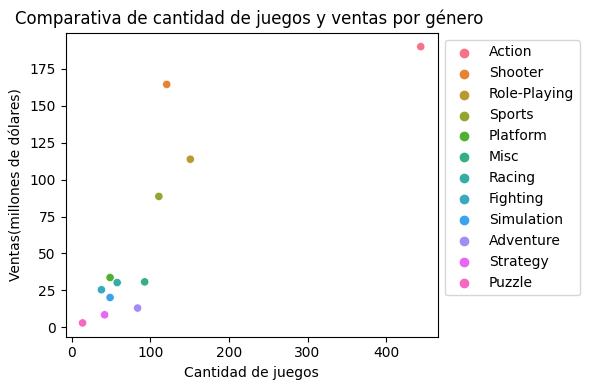

In [36]:
plt.figure(figsize=(6,4))
sns.scatterplot(data = sales_by_genre, 
                x = 'number_of_games', 
                y='sales',
               hue='genre')
plt.xlabel('Cantidad de juegos')
plt.ylabel('Ventas(millones de dólares)')
plt.title('Comparativa de cantidad de juegos y ventas por género ')
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [37]:
genre_corr = sales_by_genre['number_of_games'].corr(sales_by_genre['sales'])
print(f'Un resultado de {genre_corr:.2} indica una fuerte correlación entre ambas variables')

Un resultado de 0.82 indica una fuerte correlación entre ambas variables


Hay una preferencia clara por juegos de Acción y Shooter siendo estos géneros los dominantes en ventas, también se observa lo mencionado al comienzo del análisis referente a la dependencia de las ventas totales en función de la cantidad de juegos aunque no de forma tan fuerte por lo que hay otros factores que influyen como el género en este caso. 

## Crea un perfil de usuario para cada región

In [38]:
# Ventas de juegos por plataforma en cada región
regional_sales = filtered_games.groupby('platform').agg(north_america=('na_sales','sum'), 
                                                        europe=('eu_sales', 'sum'), 
                                                        japan=('jp_sales', 'sum')).reset_index()


In [39]:
regional_sales

,platform,north_america,europe,japan
0,3DS,39.04,31.17,67.86
1,PC,11.11,25.36,0.00
2,PS4,108.74,141.09,15.96
3,WiiU,29.21,19.85,10.88
4,XOne,93.12,51.59,0.34


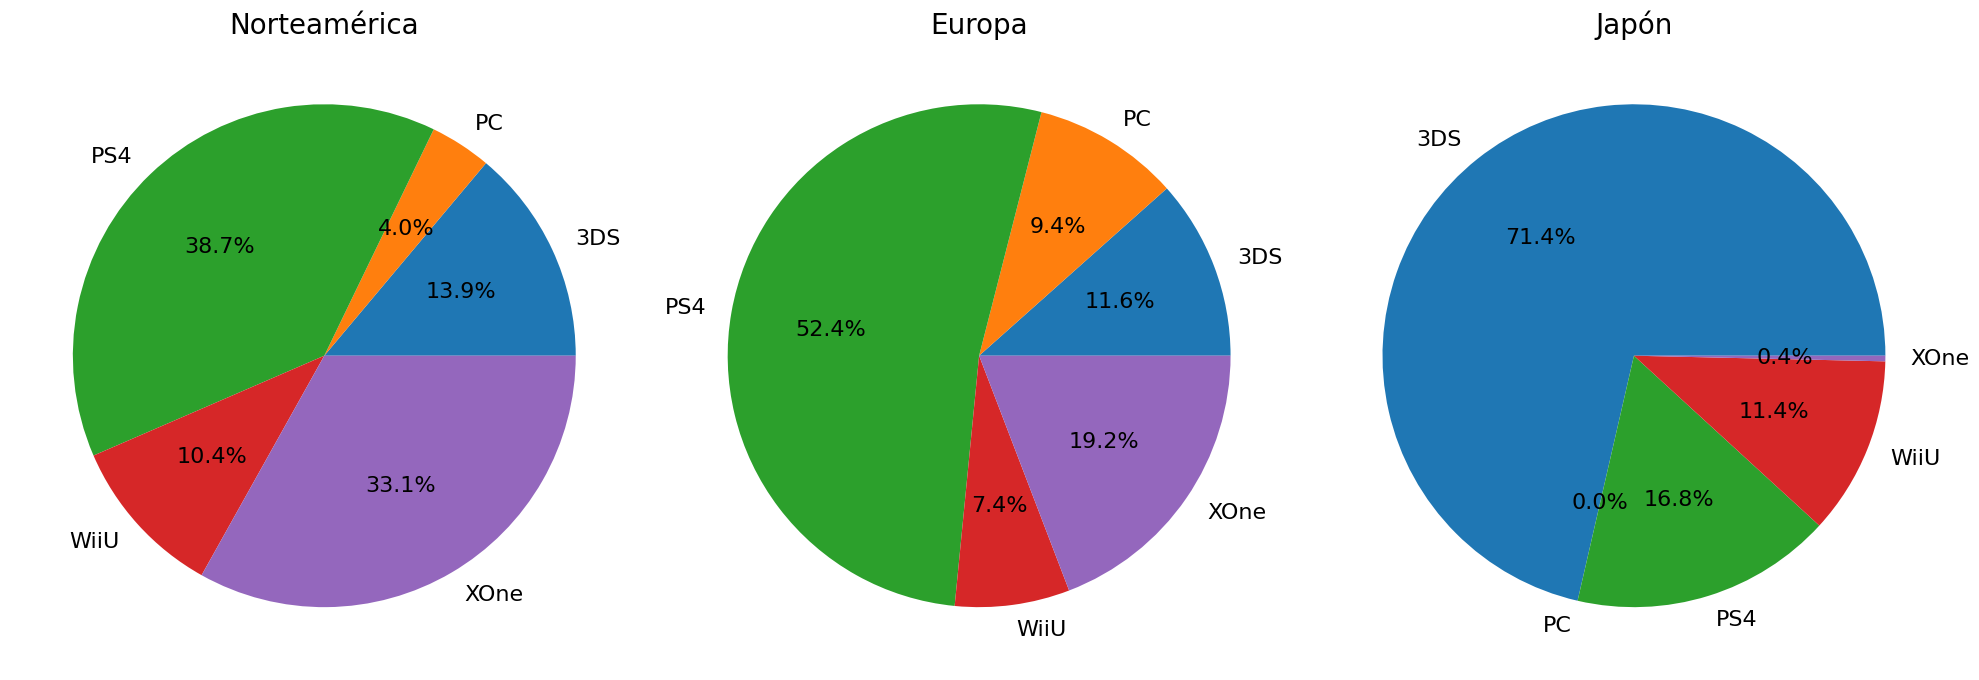

In [73]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))

# Gráfico de torta para América del Norte
axs[0].pie(regional_sales['north_america'], 
           labels=regional_sales['platform'], 
           autopct='%1.1f%%', 
           textprops={'fontsize': 16})
axs[0].set_title('Norteamérica', fontsize=20)

# Gráfico de torta para Europa
axs[1].pie(regional_sales['europe'], 
           labels=regional_sales['platform'], 
           autopct='%1.1f%%', 
           textprops={'fontsize': 16})
axs[1].set_title('Europa', fontsize=20)

# Gráfico de torta para Japón
axs[2].pie(regional_sales['japan'], 
           labels=regional_sales['platform'], 
           autopct='%1.1f%%', 
           textprops={'fontsize': 16})
axs[2].set_title('Japón', fontsize=20)

plt.tight_layout()
plt.show()

Norteamérica: Se observa una fuerte competencia entre PS4 y XOne aunque es la primera quien lleva la delantera

Europa: Aquí si hay un claro dominio de PS4 con más del 50% del mercado.

Japón: Muestra una preferencia muy grande por 3DS, la única plataforma portátil, abarcando más de dos tercios del mercado. En cuanto a las plataformas "fijas" nuevamente PS4 lleva la delantera, seguida por WiiU mientras que PC y XOne juntas no alcanzan el 1%. 

### Los cinco géneros principales.

In [41]:
top_five = filtered_games.groupby('genre')[['na_sales','eu_sales','jp_sales']].sum().reset_index()

In [83]:
top_na = top_five.nlargest(5, 'na_sales')
top_na[['genre', 'na_sales']]

,genre,na_sales
8,Shooter,74.89
0,Action,72.61
10,Sports,36.74
7,Role-Playing,36.35
4,Platform,14.02


In [84]:
top_eu = top_five.nlargest(5, 'eu_sales')
top_eu[['genre', 'eu_sales']]

,genre,eu_sales
0,Action,72.17
8,Shooter,64.36
10,Sports,37.91
7,Role-Playing,30.96
6,Racing,15.17


In [85]:
top_jp = top_five.nlargest(5, 'jp_sales')
top_jp[['genre', 'jp_sales']]

,genre,jp_sales
7,Role-Playing,38.03
0,Action,24.00
3,Misc,6.23
4,Platform,4.71
2,Fighting,4.68


NA y EU poséen patrones de consumo parecidos, compartiendo 4 géneros en sus top5 respectivos y estos casi en la misma posición.

Japón se comporta de forma distinta, aunque hay un algunos géneros en común, tienen un orden muy diferente.

### Como las clasificaciones de ESRB afectan a las ventas en regiones individuales.

In [86]:
#Hago lo explicado en el procesamiento y elimino los nulos
filter_rating = filtered_games[filtered_games['rating'].notnull()]

In [87]:
sales_by_rating= filter_rating.groupby('rating')['na_sales', 'eu_sales', 'jp_sales'].sum().reset_index()

In [89]:
sales_by_rating

,rating,na_sales,eu_sales,jp_sales
0,E,51.96,57.02,13.20
1,E10+,32.11,25.24,5.38
2,M,95.62,93.37,6.75
3,T,33.85,31.38,8.44


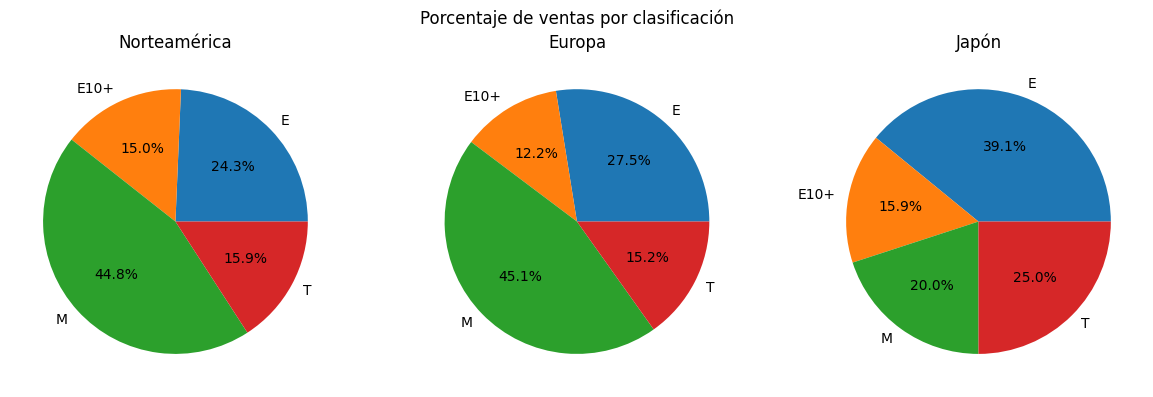

In [47]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle('Porcentaje de ventas por clasificación')
axs[0].pie(sales_by_rating['na_sales'], labels = sales_by_rating['rating'], autopct = '%1.1f%%')
axs[0].set_title('Norteamérica')

axs[1].pie(sales_by_rating['eu_sales'], labels = sales_by_rating['rating'], autopct = '%1.1f%%')
axs[1].set_title('Europa')

axs[2].pie(sales_by_rating['jp_sales'], labels = sales_by_rating['rating'], autopct = '%1.1f%%')
axs[2].set_title('Japón')

plt.tight_layout()
plt.show()

Nuevamente Norteamérica y Europa muestran hábitos de consumo parecidos teniendo para cada clasificación números cercanos y en ambos dominando los juegos de clasificación M(Mature 17+) mientras que Japón prefiere los juegos E(Everyone) más que cualquier otra categoría.

## Prueba de hipótesis

In [90]:
# Usaré un valor alpha de 5% para la todas las hipótesis
alpha = 0.05

### Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

La hipótesis nula (H0) será que la calificación promedio de ambas es igual y la hipótesis alternativa(H1) que difieren

In [49]:
# Extraer datos de interes
xone_score = filtered_games[filtered_games['platform'] == 'XOne']['user_score']
pc_score = filtered_games[filtered_games['platform'] == 'PC']['user_score']

# Prueba de Levene para evaluar como tratar las varianzas
pc_xo_lev = levene(xone_score, pc_score)

if pc_xo_lev.pvalue < alpha:
    print("Las varianzas son diferentes")
else:
    print("Las varianzas deben tratarse como iguales")

Las varianzas son diferentes


In [50]:
# Prueba de Student para H0
pc_xo_stu = ttest_ind(xone_score, pc_score, equal_var = False)

# Comparar con alpha
if pc_xo_lev.pvalue < alpha:
    print('Se rechaza la hipótesis nula. Las calificaciones de usuarios para XOne y PC son diferentes.')
else:
    print('No podemos rechazar la hipótesis nula')

Se rechaza la hipótesis nula. Las calificaciones de usuarios para XOne y PC son diferentes.


### Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

La H0 será que las calificaciones promedio para estos géneros son iguales y la alternativa que son diferentes, así buscaremos rechazar la H0

In [51]:
# Extraer datos de interes
action_scores = filtered_games[filtered_games['genre'] == 'Action']['user_score']
sports_scores = filtered_games[filtered_games['genre'] == 'Sports']['user_score']

# Prueba de Levene para evaluar como tratar las varianzas
sport_action_lev = levene(action_scores, sports_scores)

if sport_action_lev.pvalue < alpha:
    print("Las varianzas son diferentes")
else:
    print("Las varianzas deben tratarse como iguales")

Las varianzas son diferentes


In [52]:
# Realizar la prueba t de Student
sport_action_stud = ttest_ind(action_scores, sports_scores, equal_var = False)

if sport_action_stud.pvalue < alpha:
    print('Rechazamos la hipótesis nula: La prueba indica que la calificación de ambos géneros es diferente.')
else:
    print('No podemos rechazar la hipótesis nula.')

Rechazamos la hipótesis nula: La prueba indica que la calificación de ambos géneros es diferente.


## Conclusiones

El análisis demostró que aunque en el pasado hay plataformas que han vendido más que las actuales, en este mercado la mayoría de los consumidores prefieren las versiones más modernas por lo que el principal enfoque de la tienda debe ser hacia juegos de plataformas nuevas: PS4, XOne, 3DS, WiiU y PC. Es posible que haya mercado para plataformas antiguas pero es uno muy reducido y más si se trata de juegos en formato digital. 

Las regiones Norteamérica y Europa poséen el segmento del mercado más grande y tienen hábitos de consumo bastante parecidos por lo que puede emplearse la misma estrategia de mercado para ambos, estas regiones prefieren juegos de PS4 y XOne de acción, shooters y deportes antes que cualquier otro género y con clasificación M por lo que esta debiese ser la punta de lanza de la estrategia pero tampoco descuidar las otras plataformas y géneros mencionados en el análisis pues también tienen cuotas importantes.

El mercado japones es la tercera región con más ventas a nivel global y esta presenta un comportamiento distinto. Aquí las ventas de PC y XOne son virtualmente cero por lo que no es recomendable emplear recursos. No es el caso de los juegos de 3DS que dominan gran parte del mercado con PS4 y WiiU teniendo cuotas muy inferiores pero que igualmente están presentes. Los japoneses prefieren los RPG y juegos de acción con contenido apto para todo público.

Así concluye mi análisis y espero que la información brindada haga que Ice tenga ventas muy exitosas en el próximo año.